In [1]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import os
import flwr as fl
from flwr.common import Metrics

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

/home/jhmoon/venvFL/env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training on cuda using PyTorch 1.13.1+cu117 and Flower 1.3.0


In [2]:
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

In [7]:
NUM_CLIENTS = 10

BATCH_SIZE = 32


def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./data", train=True, download=True, transform=transform)
    testset = CIFAR10("./data", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

Files already downloaded and verified
Files already downloaded and verified


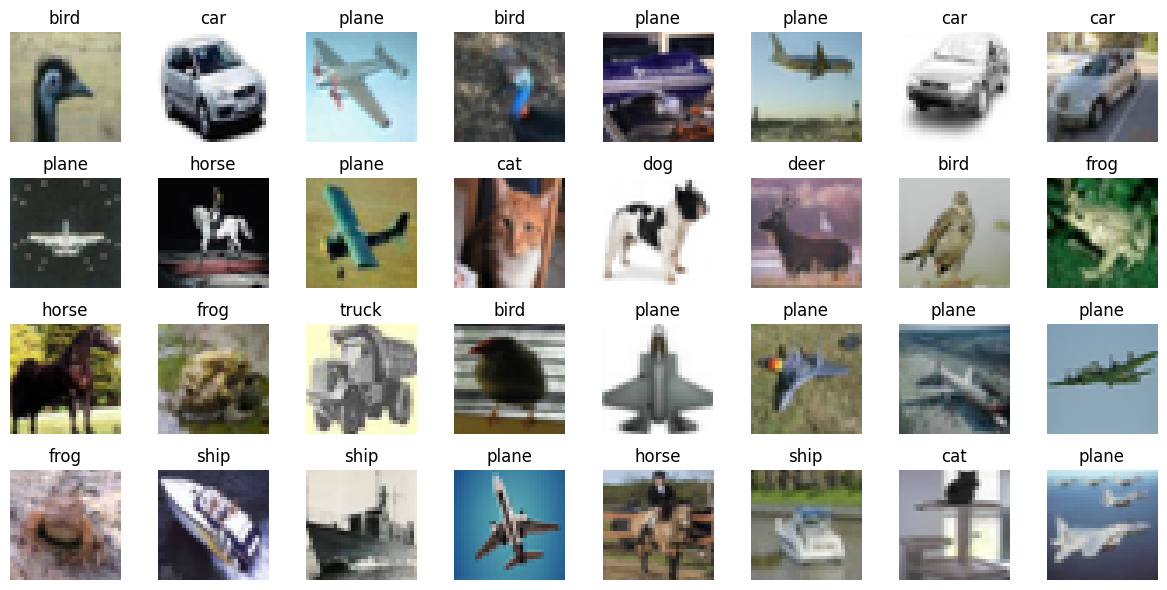

In [8]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

In [3]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
model = Net()

In [7]:
model

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [11]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.06170080828666687, accuracy 0.262
Epoch 2: validation loss 0.05927043962478638, accuracy 0.31
Epoch 3: validation loss 0.053552348852157594, accuracy 0.374
Epoch 4: validation loss 0.05310666370391846, accuracy 0.372
Epoch 5: validation loss 0.05157800054550171, accuracy 0.438
Final test set performance:
	loss 0.04927923082113266
	accuracy 0.4238


In [12]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [13]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [14]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [15]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-04-07 13:19:23,257 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-07 13:19:25,523	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-07 13:19:27,093 | app.py:179 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:117.17.189.210': 1.0, 'CPU': 32.0, 'object_store_memory': 22376773632.0, 'memory': 44753547264.0}
INFO flwr 2023-04-07 13:19:27,094 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-07 13:19:27,094 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-07 13:19:31,442 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-07 13:19:31,443 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-07 13:19:31,444 | server.py:101 | FL starting
DEBUG flwr 2023-04-07 13:19:31,444 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)


(scheduler +4m29s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +4m29s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-07 13:20:30,856 | server.py:229 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-04-07 13:20:30,890 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-07 13:20:30,891 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-04-07 13:20:55,529 | server.py:179 | evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-07 13:20:55,530 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-04-07 13:20:55,531 | server.py:215 | fit_round 2: strategy sampled 10 clients (out of 10)


(scheduler +5m39s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-07 13:21:58,040 | server.py:229 | fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-07 13:21:58,061 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 10)


(scheduler +6m39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-07 13:22:24,044 | server.py:179 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-04-07 13:22:24,045 | server.py:215 | fit_round 3: strategy sampled 10 clients (out of 10)


(scheduler +7m39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-07 13:23:25,995 | server.py:229 | fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-07 13:23:26,018 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-04-07 13:23:51,868 | server.py:179 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-04-07 13:23:51,869 | server.py:215 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-07 13:24:55,232 | server.py:229 | fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-07 13:24:55,255 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-04-07 13:25:21,181 | server.py:179 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-04-07 13:25:21,182 | server.py:215 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-07 13:26:18,369 | server.py:229 | fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-07 13:26:18,392 | server.py:165 | evaluat

History (loss, distributed):
	round 1: 0.06516894235610962
	round 2: 0.0537965033531189
	round 3: 0.051325901222229006
	round 4: 0.04886717162132263
	round 5: 0.04673297839164735

In [16]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [18]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-04-07 13:35:04,939 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-04-07 13:35:09,689	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-07 13:35:11,010 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 32.0, 'memory': 53135147828.0, 'GPU': 1.0, 'object_store_memory': 26567573913.0, 'node:117.17.189.210': 1.0}
INFO flwr 2023-04-07 13:35:11,011 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-07 13:35:11,011 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-07 13:35:14,852 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-07 13:35:14,853 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-07 13:35:14,854 | server.py:101 | FL starting
DEBUG flwr 2023-04-07 13:35:14,854 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)


(scheduler +20m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


DEBUG flwr 2023-04-07 13:36:09,535 | server.py:229 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-04-07 13:36:09,558 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-07 13:36:09,559 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-04-07 13:36:33,022 | server.py:179 | evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-04-07 13:36:33,023 | server.py:215 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-07 13:37:32,011 | server.py:229 | fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-07 13:37:32,036 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-04-07 13:37:58,443 | server.py:179 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-04-07 13:37:58,445 | server.py:215 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-04-07 13:38:59,071 | server.py:229 | fit_round 3 r

History (loss, distributed):
	round 1: 0.06452797980308533
	round 2: 0.05788971958160401
	round 3: 0.05350822124481201
History (metrics, distributed):
{'accuracy': [(1, 0.266), (2, 0.32120000000000004), (3, 0.382)]}

(raylet) [2023-04-07 13:45:09,597 E 18221 18221] (raylet) node_manager.cc:3097: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: d6123e10afd0a8dde50e0f3c53b087ee14ad7788e3c098d1ac3c94c1, IP: 117.17.189.210) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 117.17.189.210`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) [2023-04-07 13:57:09,607 E 18221 18221] (raylet) node_manager.cc:3097: 2 Workers (tasks / actors) killed

: 